# This assignment is on image registration using perpective (also known as homography) transformation

#### This notebook shows the use of differentiable mutual information for image registration. Your main task is to change that registration cost function to normalizing gradient. The code will run a lot faster. 

#### You are required to edit some portions of a two functions as indicated in the instructions. You will also answer two questions provided in two cells.

#### You will find outputs and expected behaviour of a sucessful implementation towards the end of the notebook.

#### You will edit only the portions of the code/cell you are instructed to do. Top of each cell indicates wherether you should or should not edit that cell.

#### Look for submission instructions in eClass.

In [1]:
# Do not edit this cell
import os
from tqdm import tqdm
import random
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.exposure import equalize_hist
from skimage.util import img_as_ubyte


# for local hist eq
from skimage.morphology import disk
from skimage.filters import rank

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

d:\Conda\envs\cynthia_clone\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
batch_size = 32

I_dir = "D:\\Cynthia_Data\\2022_09_15\\combined\\opensfm\\undistorted\\images_rgb"
J_dir = "D:\\Cynthia_Data\\2022_09_15\\thermal\\normalized_unmapped"
I_files = [f"{I_dir}/{fname}" for fname in os.listdir(I_dir) if fname.endswith(".tif")]
J_files = [f"{J_dir}/{fname.split('.')[0]}.tiff" for fname in os.listdir(I_dir) if fname.endswith(".tif")]
print(len(I_files), len(J_files))


## shuffle lists together - worse... (means performance dpends on data)
# temp = list(zip(I_files, J_files))
# random.shuffle(temp)
# res1, res2 = zip(*temp)
# # res1 and res2 come out as tuples, and so must be converted to lists.
# I_files, J_files = list(res1), list(res2)

# ## local hist eq -- too slow
# ## instead just do hist eq
# footprint = disk(300)
# start = 400 
# I_imgs = np.array([rgb2gray(io.imread(fname)).astype(np.float32) for fname in I_files[start:start+batch_size]])
# J_imgs = np.array([equalize_hist(io.imread(fname)).astype(np.float32) for fname in J_files[start:start+batch_size]])


## normal -- load all images
I_imgs = np.array([equalize_hist(img_as_ubyte(rgb2gray(io.imread(fname)))).astype(np.float32) for fname in tqdm(I_files)])
J_imgs = np.array([equalize_hist(io.imread(fname)).astype(np.float32) for fname in tqdm(J_files)])

# I_imgs = np.array([rgb2gray(io.imread(fname)).astype(np.float32) for fname in I_files[400:400+batch_size]])
# J_imgs = np.array([io.imread(fname).astype(np.float32) for fname in J_files[400:400+batch_size]])
print(I_imgs.shape,J_imgs.shape)




824 824


100%|██████████| 824/824 [02:08<00:00,  6.42it/s]


(824, 1216, 1622) (824, 1216, 1622)


In [2]:
## compute mutual infomration for all original pairs
def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

## sort indices by MI
lower_bound = 0.3
upper_bound = 1.0
zipped_list = []
print("Sorting by MI")
for k in tqdm(range(I_imgs.shape[0])):
    MI_value = histogram_mutual_information(I_imgs[k], J_imgs[k])
    if lower_bound <= MI_value <= upper_bound:
        zipped_list.append((k, MI_value))
zipped_list.sort(key=lambda a: a[1], reverse=True)
print(len(zipped_list))
# exit(0)

# reduce batch size if needed
batch_size = 64
batch_size = min(batch_size, len(zipped_list))
batch_idxs = [item[0] for item in zipped_list[:batch_size]]   
print(len(batch_idxs), batch_size)

Sorting by MI


NameError: name 'I_imgs' is not defined

In [ ]:
# You can uncomment the mounting from Google drive instructions.
# You can also edit the path of the images if required.
# Do not edit anything else in this cell.

#from google.colab import drive
#drive.mount('/content/drive')

# I = rgb2gray(io.imread("D:\\Cynthia_Data\\2022_09_15\\combined\\opensfm\\undistorted\\images_rgb\\img_00007.jpeg.tif")).astype(np.float32) # fixed image
# J = io.imread("D:\\Cynthia_Data\\2022_09_15\\thermal\\normalized_unmapped\\img_00007.tiff") # moving image


batch_size = 128

I_dir = "D:\\Cynthia_Data\\2022_09_15\\combined\\opensfm\\undistorted\\images_rgb"
J_dir = "D:\\Cynthia_Data\\2022_09_15\\thermal\\normalized_unmapped"
I_files = [f"{I_dir}/{fname}" for fname in os.listdir(I_dir) if fname.endswith(".tif")]
J_files = [f"{J_dir}/{fname}" for fname in os.listdir(J_dir) if fname.endswith(".tiff")]
random.shuffle(I_files)
random.shuffle(J_files)

I_imgs = np.array([rgb2gray(io.imread(fname)).astype(np.float32) for fname in I_files[:batch_size]])
J_imgs = np.array([io.imread(fname).astype(np.float32)/(256*256-1.0) for fname in J_files[:batch_size]])
print(I_imgs.shape,J_imgs.shape)



# I = I_imgs[7]
# J = J_imgs[7]

nChannel = 1 # gray scale image

# Equalization
# footprint = disk(300)
# J = rank.equalize(J, footprint=footprint)
# J = J.astype(np.float32)/(256*256-1.0)

%matplotlib inline
fig=plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(I_imgs[8],cmap="gray")
plt.title("Fixed Image")
fig.add_subplot(1,2,2)
plt.imshow(J_imgs[8],cmap="gray")
plt.title("Moving Image")
plt.show()

: 

In [ ]:
print(np.amax(I_imgs),np.amax(J_imgs))

1.0 0.87530327


In [ ]:
# Do not edit this cell

L = 11         # Gaussian pyramid level
downscale = 1.5  # downscale factor for the gaussian pyramid
# pyramid_I = tuple(pyramid_gaussian(I_imgs[0], downscale=downscale, multichannel=False))
# pyramid_J = tuple(pyramid_gaussian(J, downscale=downscale, multichannel=False))

pyramid_I_list, pyramid_J_list = None, None
for k in tqdm(range(batch_size)):
  pyramid_I_temp = list(pyramid_gaussian(I_imgs[k], downscale=downscale, multichannel=False))
  pyramid_J_temp = list(pyramid_gaussian(J_imgs[k], downscale=downscale, multichannel=False))
  pyramid_I_temp = [np.expand_dims(pyramid_I_temp[s], axis=0) for s in range(len(pyramid_I_temp))]
  pyramid_J_temp = [np.expand_dims(pyramid_J_temp[s], axis=0) for s in range(len(pyramid_J_temp))]

  if pyramid_J_list is None:
    pyramid_I_list = pyramid_I_temp.copy()
    pyramid_J_list = pyramid_J_temp.copy()
  else:
    pyramid_I_list = tuple([np.concatenate((pyramid_I_list[s], pyramid_I_temp[s])) for s in range(L)])
    pyramid_J_list = tuple([np.concatenate((pyramid_J_list[s], pyramid_J_temp[s])) for s in range(L)])
    

# # create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,h_lst,w_lst,xy_lst,ind_lst=[],[],[],[],[],[]
for s in tqdm(range(L)):
  # print(pyramid_I[s].shape)
  # I_, J_ = torch.tensor(pyramid_I[s].astype(np.float32)).to(device), torch.tensor(pyramid_J[s].astype(np.float32)).to(device)
  I_, J_ = torch.tensor(pyramid_I_list[s].astype(np.float32)).to(device), torch.tensor(pyramid_J_list[s].astype(np.float32)).to(device)

  I_lst.append(I_)
  J_lst.append(J_)
  # h_, w_ = I_lst[s].shape[0], I_lst[s].shape[1]
  h_, w_ = I_lst[s].shape[1], I_lst[s].shape[2]

  h_lst.append(h_)
  w_lst.append(w_)

  y_, x_ = torch.meshgrid([torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
  y_, x_ = 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
  xy_ = torch.stack([x_,y_],2)
  xy_lst.append(xy_)

  0%|          | 0/128 [00:00<?, ?it/s]C:\Users\NADIR\AppData\Local\Temp\ipykernel_15940\1431657412.py:10: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  pyramid_I_temp = list(pyramid_gaussian(I_imgs[k], downscale=downscale, multichannel=False))
C:\Users\NADIR\AppData\Local\Temp\ipykernel_15940\1431657412.py:11: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  pyramid_J_temp = list(pyramid_gaussian(J_imgs[k], downscale=downscale, multichannel=False))
100%|██████████| 11/11 [00:01<00:00, 10.29it/s]


### The following cell implements homography transformation using matrix exponential.

Question (10% weight): How would you modify it to implement an affine transformation using matrix exponential?

Write your answer here:...

For affine transfom use the following 6 basis matrices in the matrix exponential as opposed to 8 for the homography:

$exp(\sum_{i=1}^6\theta_iB_i)=\sum_{k=0}^\infty\frac{[\sum_{i=1}^6\theta_iB_i]^k}{k!}$, where

$
B_1=\begin{bmatrix}
0 & 0 & 1\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}
B_2=\begin{bmatrix}
0 & 0 & 0\\
0 & 0 & 1\\
0 & 0 & 0
\end{bmatrix}
B_3=\begin{bmatrix}
0 & 1 & 0\\
0 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}$




$B_4=\begin{bmatrix}
0 & 0 & 0\\
1 & 0 & 0\\
0 & 0 & 0
\end{bmatrix}
B_5=\begin{bmatrix}
1 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & 0
\end{bmatrix}
B_6=\begin{bmatrix}
0 & 0 & 0\\
0 & -1 & 0\\
0 & 0 & 1
\end{bmatrix}$


In [ ]:
# Do not edit this cell

class HomographyNet(nn.Module):
  def __init__(self):
    super(HomographyNet, self).__init__()
    # perspective transform basis matrices

    self.B = torch.zeros(8,3,3).to(device)
    self.B[0,0,2] = 1.0
    self.B[1,1,2] = 1.0
    self.B[2,0,1] = 1.0
    self.B[3,1,0] = 1.0
    self.B[4,0,0], self.B[4,1,1] = 1.0, -1.0
    self.B[5,1,1], self.B[5,2,2] = -1.0, 1.0
    self.B[6,2,0] = 0.0
    self.B[7,2,1] = 0.0

    self.v = torch.nn.Parameter(torch.zeros(8,1,1).to(device), requires_grad=True)

  # This function computes forward transform matrix
  def forward(self):
    return MatrixExp(self.B,self.v)

  # This function computes inverse transform matrix
  def inverse(self):
    return MatrixExp(self.B,-self.v)

def MatrixExp(B,v):
    C = torch.sum(B*v,0)
    A = torch.eye(3).to(device)
    H = torch.eye(3).to(device)
    for i in torch.arange(1,10):
        A = torch.mm(A/i,C)
        H = H + A
    return H    

In [ ]:
# Do not edit this cell

def PerspectiveWarping(I, H, xv, yv):

  # apply transformation in the homogeneous coordinates
  xvt = (xv*H[0,0]+yv*H[0,1]+H[0,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  yvt = (xv*H[1,0]+yv*H[1,1]+H[1,2])/(xv*H[2,0]+yv*H[2,1]+H[2,2])
  J = F.grid_sample(I,torch.stack([xvt,yvt],2).unsqueeze(0),align_corners=False).squeeze()
  return J

# s=0
# Jw_ = PerspectiveWarping(J_lst[s].unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
# print(Jw_.shape)

### Complete a multi-resolution loss function in the cell below for Normalized Gradient Loss. Make sure that your loss function makes use of both the forward and the inverse transforms

In [ ]:
# Edit this cell to complete multi-resolution_loss function

def multi_resolution_loss():
  # loss=0.0
  # for s in np.arange(L-1,-1,-1):
  #   Jw_ = PerspectiveWarping(J_lst[s].unsqueeze(0).unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
  #   Iw_ = PerspectiveWarping(I_lst[s].unsqueeze(0).unsqueeze(0), homography_net.inverse(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
  #   ng = NGF(I_lst[s],Jw_)
  #   ng2 = NGF(J_lst[s],Iw_)
  #   loss = loss + ng + ng2
  # return loss

  # loss=0.0
  # for s in np.arange(L-1,-1,-1):
  #   for k in range(batch_size):
  #     Jw_ = PerspectiveWarping(J_lst[s][k].unsqueeze(0).unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
  #     Iw_ = PerspectiveWarping(I_lst[s][k].unsqueeze(0).unsqueeze(0), homography_net.inverse(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
  #     ng = NGF(I_lst[s][k],Jw_)
  #     ng2 = NGF(J_lst[s][k],Iw_)
  #     loss += (ng + ng2)/batch_size

  loss=0.0
  for s in np.arange(L-1,-1,-1):
    Jw_ = PerspectiveWarping(J_lst[s].unsqueeze(0), homography_net(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
    Iw_ = PerspectiveWarping(I_lst[s].unsqueeze(0), homography_net.inverse(), xy_lst[s][:,:,0], xy_lst[s][:,:,1]).squeeze()
    ng = NGF(I_lst[s],Jw_)
    ng2 = NGF(J_lst[s],Iw_)
    loss += (ng + ng2)
  return loss

## Implement Normalized Gradient loss between two images

$||\frac{\nabla I}{||\nabla I||+\epsilon}-\frac{\nabla J}{||\nabla J||+\epsilon}||^2$

Here $||.||$ refers to Euclidean norm. $\epsilon$ is a very small positive number to avoid division by zero. Here's is some information on this loss: http://www.mathcs.emory.edu/~haber/pubs/ngf.pdf The function NGF should implement the action of this mathematical formula.

Question (5% weight): If image intensities appear reversed in one of the images, which loss between normalized gradient and mutual information is likely to work better? Also, if the images appear to have less textures, which one is going to work better?

Write Your answer:...

MI should work well for both the cases. However, NG may work alright for the intensity reversal case. NG is not going to work for texture-less areas due to the lack of image gradient information in those areas.

In [ ]:
# Edit this cell to complete the two functions. Follow specific instructions

# Fill in gradient function
# Do not change function definition 'def gradient(I):' 
# Do not change the last line 'return Ix,Iy'
# def gradient(I):
#     h = I.shape[0]
#     w = I.shape[1]
        
#     I = F.pad(I.unsqueeze(0).unsqueeze(0),(1,1,1,1),'replicate').squeeze()
    
#     # Write central finite difference formula for Ix and Iy
#     # Do not use any for loop
#     Ix = 0.5*(I[1:h+1,2:w+2]-I[1:h+1,0:w])
#     Iy = 0.5*(I[2:h+2,1:w+1]-I[0:h,1:w+1])

#     return Ix,Iy

# # # Fill in NGF function
# # # Do not change function definition 'def NGF(I,J):' 
# # # Do not change the last line 'return ngf_loss'
# def NGF(I,J):
#     Ix,Iy = gradient(I)
#     Jx,Jy = gradient(J)
    
#     Imag = torch.sqrt(Ix**2 + Iy**2 + 1e-8)
#     Jmag = torch.sqrt(Jx**2 + Jy**2 + 1e-8)
    
#     ngf_loss = torch.mean((Ix/Imag - Jx/Jmag)**2) + torch.mean((Iy/Imag - Jy/Jmag)**2)
    
#     return ngf_loss

def gradient(I):
    h = I.shape[1]
    w = I.shape[2]
        
    I = F.pad(I.unsqueeze(0),(1,1,1,1),'replicate').squeeze()
    
    # Write central finite difference formula for Ix and Iy
    # Do not use any for loop
    Ix = 0.5*(I[:,1:h+1,2:w+2]-I[:,1:h+1,0:w])
    Iy = 0.5*(I[:,2:h+2,1:w+1]-I[:,0:h,1:w+1])

    return Ix,Iy

# Fill in NGF function
# Do not change function definition 'def NGF(I,J):' 
# Do not change the last line 'return ngf_loss'
def NGF(I,J):

    Ix,Iy = gradient(I)
    Jx,Jy = gradient(J)
    
    Imag = torch.sqrt(Ix**2 + Iy**2 + 1e-8)
    Jmag = torch.sqrt(Jx**2 + Jy**2 + 1e-8)
    
    ngf_loss = torch.mean((Ix/Imag - Jx/Jmag)**2) + torch.mean((Iy/Imag - Jy/Jmag)**2)
    
    return ngf_loss



# NGF(I_lst[0],Jw_) # WORKS!

In [ ]:
# You can change the learning rate in this cell

homography_net = HomographyNet().to(device)

optimizer = optim.Adam(homography_net.parameters(), 0.75e-2, amsgrad=True)

In [ ]:
# To run your code, leave this cell as it is
# To run mutul information-based registration, uncomment #loss = multi_resolution_MINE_loss()
# and comment loss = multi_resolution_loss()
# Do not edit anything else in this cell
for itr in tqdm(range(100)):
  optimizer.zero_grad()
  loss = multi_resolution_loss()
  if itr%10 == 0:
    print("Itr:",itr,"Loss value:","{:.4f}".format(loss.item()))
  loss.backward()
  optimizer.step()
print("Itr:",itr+1,"Loss value:","{:.4f}".format(loss.item()))

  0%|          | 0/100 [00:00<?, ?it/s]

Itr: 0 Loss value: 39.6699


  2%|▏         | 2/100 [02:37<2:08:33, 78.71s/it]


KeyboardInterrupt: 

Mutual information before registration: 0.2773
Mutual information after registration: 0.3700
Transformation matrix:
[[ 1.0155408   0.00530284  0.03393707]
 [-0.00860073  0.9436374  -0.06704156]
 [ 0.          0.          1.0434625 ]]



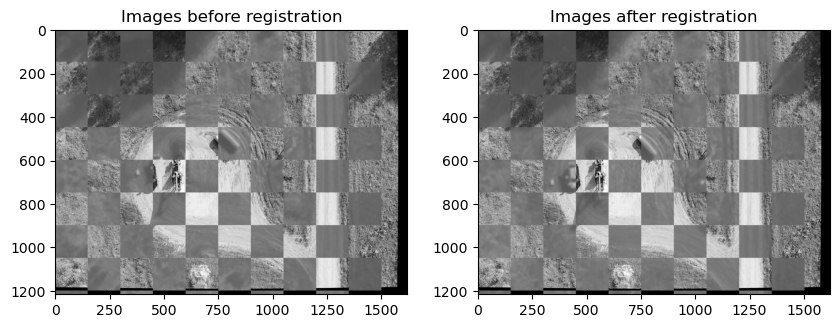

In [ ]:
# Do not edit this cell

def histogram_mutual_information(image1, image2):
    hgram, x_edges, y_edges = np.histogram2d(image1.ravel(), image2.ravel(), bins=100)
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

# J = io.imread("D:\\Cynthia_Data\\2022_09_15\\thermal\\normalized_unmapped\\img_00007.tiff").astype(np.float32)/(256*256-1.0)

I = I_imgs[7]
J = J_imgs[7]
I_t = torch.tensor(I).to(device)
J_t = torch.tensor(J).to(device)
H = homography_net()
J_w = PerspectiveWarping(J_t.unsqueeze(0).unsqueeze(0), H , xy_lst[0][:,:,0], xy_lst[0][:,:,1]).squeeze()

D = J_t - I_t
D_w = J_w - I_t

print("Mutual information before registration:", "{:.4f}".format(histogram_mutual_information(I,J)))
print("Mutual information after registration:", "{:.4f}".format(histogram_mutual_information(I,J_w.cpu().detach().numpy())))

print("Transformation matrix:")
print(H.cpu().detach().numpy())
print("")

Ra = I_t.clone()
Rb = I_t.clone()
b = 150
for i in torch.arange(0,I_t.shape[0]/b,1).int():
  for j in torch.arange(i%2,np.floor(I_t.shape[1]/b),2).int():
    Rb[i*b:(i+1)*b,j*b:(j+1)*b] = J_t[i*b:(i+1)*b,j*b:(j+1)*b].clone()
    Ra[i*b:(i+1)*b,j*b:(j+1)*b] = J_w[i*b:(i+1)*b,j*b:(j+1)*b].clone()
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(Rb.cpu().data,cmap="gray")
plt.title("Images before registration")
fig.add_subplot(1,2,2)
plt.imshow(Ra.cpu().data,cmap="gray")         
plt.title("Images after registration")
plt.show()

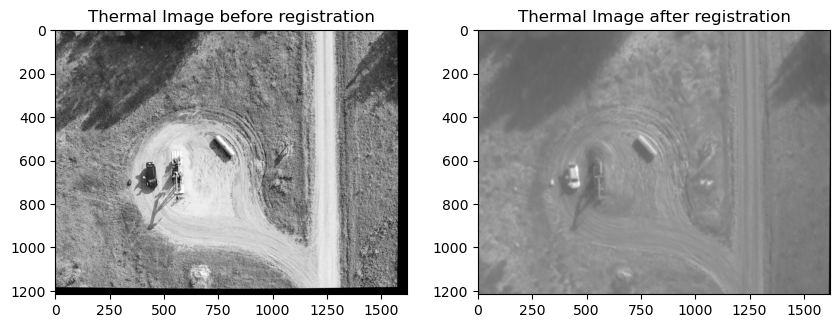

In [ ]:
%matplotlib inline
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
plt.imshow(I_t.cpu().data,cmap="gray")
plt.title("Thermal Image before registration")
fig.add_subplot(1,2,2)
plt.imshow(J_w.cpu().data,cmap="gray")         
plt.title("Thermal Image after registration")
plt.show()